In [1]:
import tqdm
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
plt.style.use('default')

from utils.model_measure import print_regression_measure, measure_regression
from sklearn.metrics import root_mean_squared_error

# 1. Dataset

a regression dataset

In [2]:
from sklearn.datasets import load_diabetes
data_X, data_Y = load_diabetes(return_X_y=True, as_frame=False)

n_samples = len(data_X)

# sample weights
rng = np.random.default_rng(seed=42)
data_weight = rng.normal(loc=0.0, scale=1.0, size=n_samples)
data_weight = np.abs(data_weight) + 1.0

train_idx, test_idx = train_test_split(range(n_samples), test_size=0.3, random_state=0)
train_X, test_X = data_X[train_idx], data_X[test_idx]
train_Y, test_Y = data_Y[train_idx], data_Y[test_idx]
train_weight, test_weight = data_weight[train_idx], data_weight[test_idx]

print('\nShape of dataset:', data_X.shape, data_Y.shape, data_weight.shape,
      '\nShape of training set:', train_X.shape, train_Y.shape, train_weight.shape,
      '\nShape of testing set:', test_X.shape, test_Y.shape, test_weight.shape)


Shape of dataset: (442, 10) (442,) (442,) 
Shape of training set: (309, 10) (309,) (309,) 
Shape of testing set: (133, 10) (133,) (133,)


Text(0.5, 1.0, 'Distribution of target')

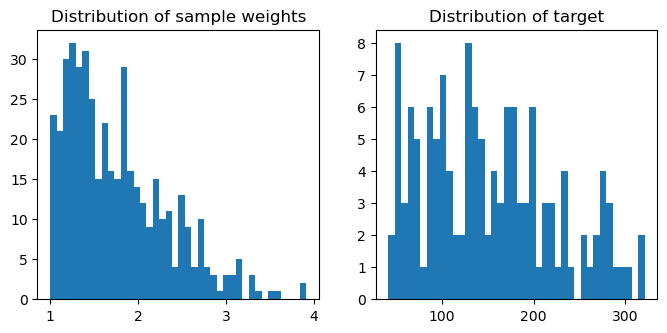

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

ax = axes[0]
ax.hist(data_weight, bins=40)
ax.set_title('Distribution of sample weights')

ax = axes[1]
ax.hist(test_Y, bins=40)
ax.set_title('Distribution of target')

# 2. Weighted bootstrap (bagging)



In [4]:
import utils.bagging_model
import importlib
importlib.reload(utils.bagging_model)

from utils.bagging_model import WeightedBaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [5]:
def model_evaluation(model, train_X, train_Y, test_X, test_Y, train_weight, test_weight, weighted_fitting=False):
    
    if weighted_fitting:
        model.fit(train_X, train_Y, train_weight)
    else:
        model.fit(train_X, train_Y)
    
    measure = dict({'oob_rmse' : model.oob_score_})

    train_Y_pred = model.predict(train_X)
    test_Y_pred = model.predict(test_X)

    train_m = measure_regression(train_Y, train_Y_pred, train_weight)
    test_m  = measure_regression(test_Y, test_Y_pred, test_weight)

    measure.update({f'train_{k}' : v for k, v in train_m.items()})
    measure.update({f'test_{k}' : v for k, v in test_m.items()})
    
    return measure

In [6]:
model = WeightedBaggingRegressor(
    estimator = DecisionTreeRegressor(),
    n_estimators = 100,
    bootstrap = True,
    bootstrap_features = False,
    max_samples = 1.0,
    max_features = None,
    weighted_bootstrap = False,
    weighted_training = False,
    oob_score = True,
    random_state = 0,
    n_jobs = 10,
    verbose = 0)

peformance = {}

model.set_params(weighted_bootstrap=False, weighted_training=False)
peformance['BU-TU'] = model_evaluation(model, train_X, train_Y, test_X, test_Y, train_weight, test_weight, weighted_fitting=False)

model.set_params(weighted_bootstrap=True, weighted_training=False)
peformance['BW-TU'] = model_evaluation(model, train_X, train_Y, test_X, test_Y, train_weight, test_weight, weighted_fitting=True)

model.set_params(weighted_bootstrap=False, weighted_training=True)
peformance['BU-TW'] = model_evaluation(model, train_X, train_Y, test_X, test_Y, train_weight, test_weight, weighted_fitting=True)

model.set_params(weighted_bootstrap=True, weighted_training=True)
peformance['BW-TW'] = model_evaluation(model, train_X, train_Y, test_X, test_Y, train_weight, test_weight, weighted_fitting=True)

pd.DataFrame.from_dict(peformance).T

,oob_rmse,train_mae,train_mse,train_rmse,train_mape,train_r2,test_mae,test_mse,test_rmse,test_mape,test_r2
BU-TU,58.890680,17.521964,465.908303,21.584909,0.157827,0.924939,47.086481,3388.687169,58.212431,0.394759,0.299773
BW-TU,57.513884,16.348199,442.414255,21.033646,0.145335,0.915051,47.164956,3469.393474,58.901557,0.400382,0.287324
BU-TW,58.953164,17.664953,471.378941,21.711263,0.155935,0.924777,47.057284,3398.188004,58.293979,0.395456,0.302158
BW-TW,57.943491,16.335283,442.368467,21.032557,0.145580,0.915552,48.350840,3613.238262,60.110218,0.415339,0.261433


# 3. Comparison test

- Unweighted BaggingRegressor vs RandomForestRegressor

Based on the model principle, if sample weights for bootstrapping process are not considered in `WeightedBaggingRegressor`, the two models should have the same performance.

Consider the randomization process of bootstrapping, repeated trials are conducted to evaluate the performance of two models.

## 3.1 Repeated trials

In [7]:
def model_evaluation(model, train_X, train_Y, test_X, test_Y):

    model.fit(train_X, train_Y)

    measure = dict({'oob_r2' : model.oob_score_})

    train_Y_pred = model.predict(train_X)
    test_Y_pred = model.predict(test_X)

    train_m = measure_regression(train_Y, train_Y_pred)
    test_m  = measure_regression(test_Y, test_Y_pred)

    measure.update({f'train_{k}' : v for k, v in train_m.items()})
    measure.update({f'test_{k}' : v for k, v in test_m.items()})

    return measure
# =============================================================================

In [ ]:
n_trials = 200

seeds = np.random.randint(0, 1e6, n_trials).tolist()
n_estimators = np.random.randint(100, 500, n_trials).tolist()

score_wb = []
score_rf = []

for seed, n_estimator in tqdm.tqdm(zip(seeds, n_estimators)):

    model = WeightedBaggingRegressor(
        n_estimators = n_estimator,
        random_state = seed,
        estimator = DecisionTreeRegressor(),
        bootstrap = True,
        bootstrap_features = False,
        max_samples = 1.0,
        max_features = None,
        weighted_bootstrap = False, weighted_training = False,
        oob_score = True,
        n_jobs = 10, verbose = 0)

    measure = model_evaluation(model, train_X, train_Y, test_X, test_Y)
    measure.update({'seed' : seed, 'n_estimator' : n_estimator})
    score_wb.append(measure)
    
    
    model = RandomForestRegressor(
        n_estimators = n_estimator,
        random_state = seed,
        bootstrap = True,
        max_samples = 1.0,
        max_features = 1.0,
        oob_score = root_mean_squared_error,
        n_jobs = 10, verbose = 0)

    measure = model_evaluation(model, train_X, train_Y, test_X, test_Y)
    measure.update({'seed' : seed, 'n_estimator' : n_estimator})
    score_rf.append(measure)


score_wb = pd.DataFrame(score_wb)
score_rf = pd.DataFrame(score_rf)

0it [00:00, ?it/s]

## 3.2 Paired t-test of performance

In [ ]:
# paired t-test
# Calculate the t-test on TWO RELATED samples of scores, a and b.
# This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
# P > 0.05 : no enough evidence to reject the null hypothesis that model performance is the same
from scipy.stats import ttest_rel

for col in score_rf.columns:
    
    t, p = ttest_rel(score_wb[col], score_rf[col])
    print(f'{col:>11}: t = {t:>7.3f}, p = {p:.3f}')